<a href="https://colab.research.google.com/github/mborkhat/MTech_AI/blob/main/CW/20230813_Lab_4_MTech_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tell SOmething ABout Data Set and WHat we are Building

<a href="https://colab.research.google.com/github/bilalProgTech/mtech-nmims/blob/master/speech-recognition/Lab-Work/20220814-Lab-4-MTech-AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'
!kaggle competitions download -c tensorflow-speech-recognition-challenge
!unzip *.zip

100% 3.50G/3.50G [00:31<00:00, 149MB/s]
100% 3.50G/3.50G [00:31<00:00, 121MB/s]
Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                


In [ ]:
#chmod 600 /content/kaggle.json

In [ ]:
!7za x 'train.7z'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav                                                               0% 40 - train/audio/_background_noise_/exercise_bike.wav                                                            0% 41 - train/audio/_background_noise_/pink_n

In [ ]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import IPython.display as ipd
import plotly as py
import plotly.graph_objs as go

In [ ]:
files = []
target_series = []
for dirname, _, filenames in os.walk('/content/train/audio/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        target = filepath.split('/')[-2]
        if target == 'happy' or target == 'stop' or target == 'wow':
            target_series.append(target)
            files.append(filepath)
data = pd.DataFrame(target_series, columns=['target'])
data['filename'] = files
data = data.sample(frac=1)
data = data.reset_index(drop=True)
data.head()

,target,filename
0,wow,/content/train/audio/wow/8d9cc260_nohash_0.wav
1,happy,/content/train/audio/happy/cd68e997_nohash_0.wav
2,stop,/content/train/audio/stop/e1469561_nohash_4.wav
3,wow,/content/train/audio/wow/0362539c_nohash_0.wav
4,wow,/content/train/audio/wow/56f78b7e_nohash_2.wav


In [ ]:
def get_audio_feature_plots(path, target):
    x , sr = librosa.load(path)
    plt.figure(figsize=(20, 5))
    plt.title('Waveplot of '+target)
    librosa.display.waveshow(x, sr=sr)
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.title('MFCC Spectral of '+target)
    mfccs = librosa.feature.mfcc(y=x, sr=sr) # n_mfcc
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    print(mfccs.shape)
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.title('Mel Spectrogram of '+target)
    mel_spec = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time')
    plt.show()

    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title('Zero Crossing Rate of '+target)
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

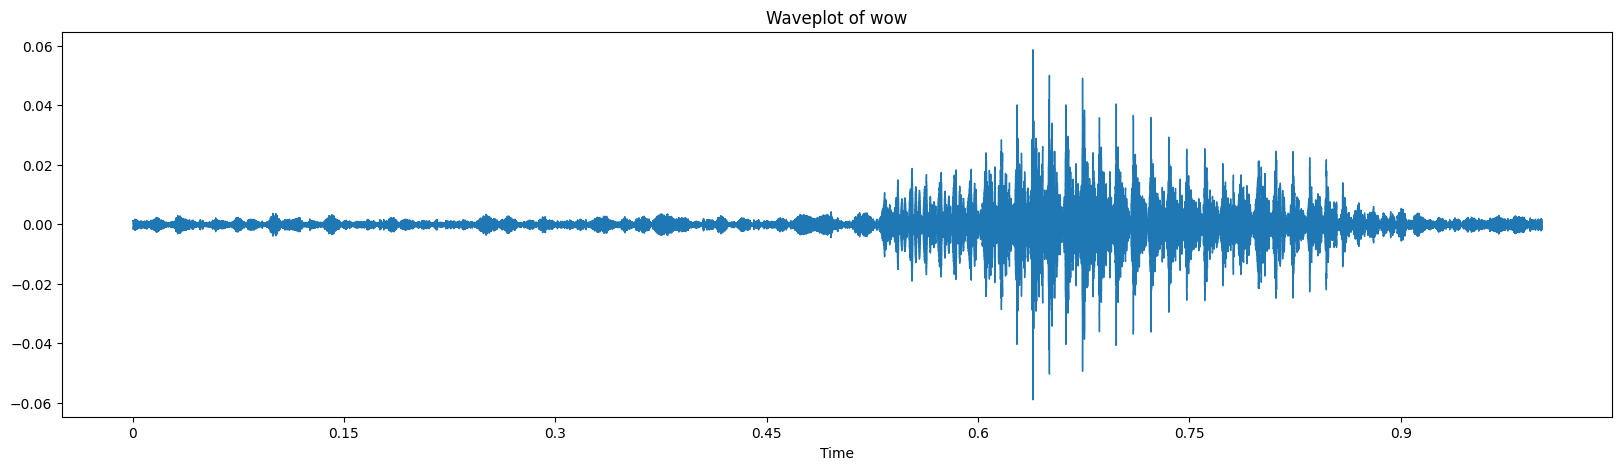

(20, 44)


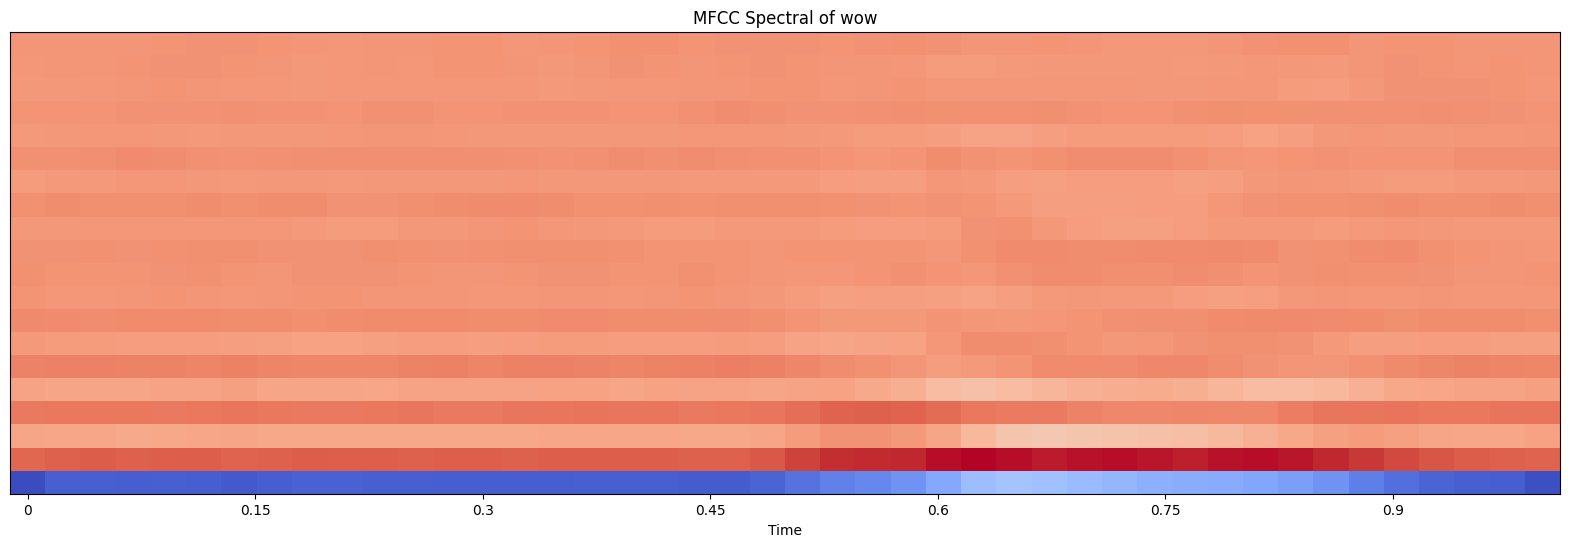

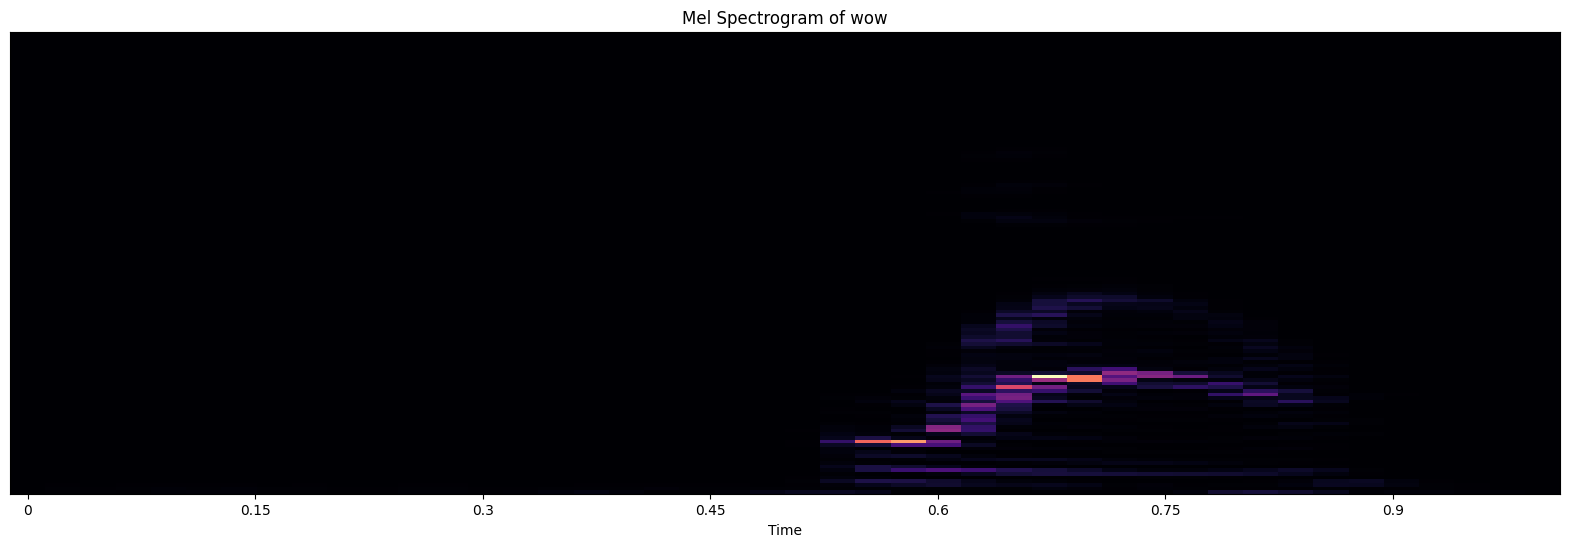

Sum of zero crossing  1567


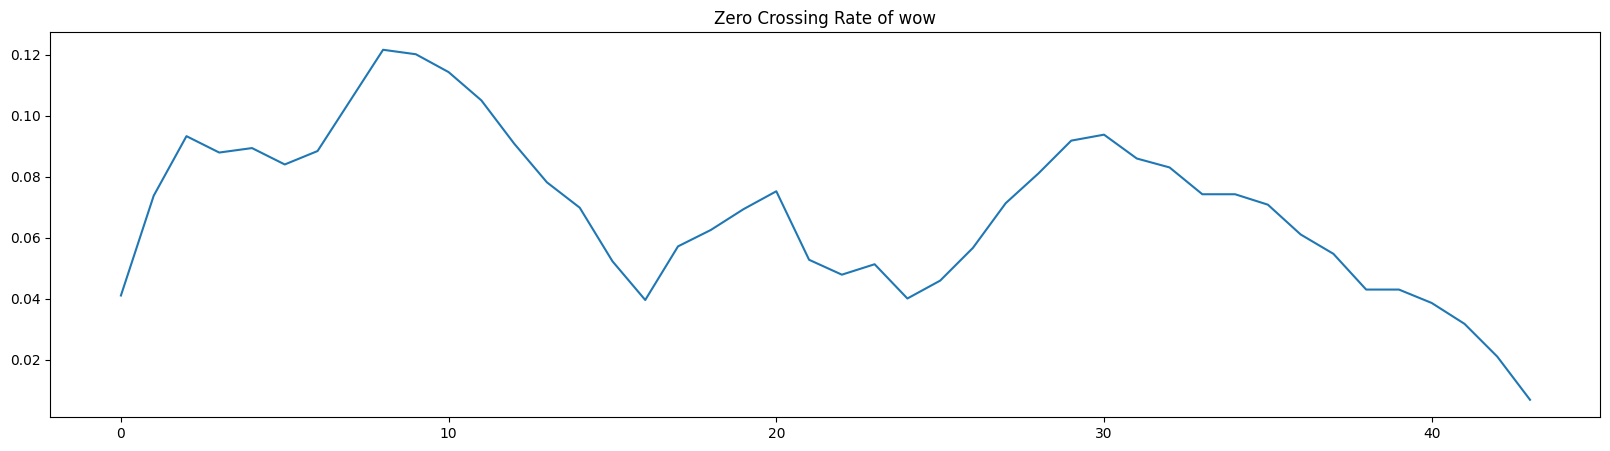

In [ ]:
sample = data[(data['target'] == 'wow')].sample(1)
get_audio_feature_plots(sample['filename'].values[0], sample['target'].values[0])
ipd.Audio(sample.filename.values[0])

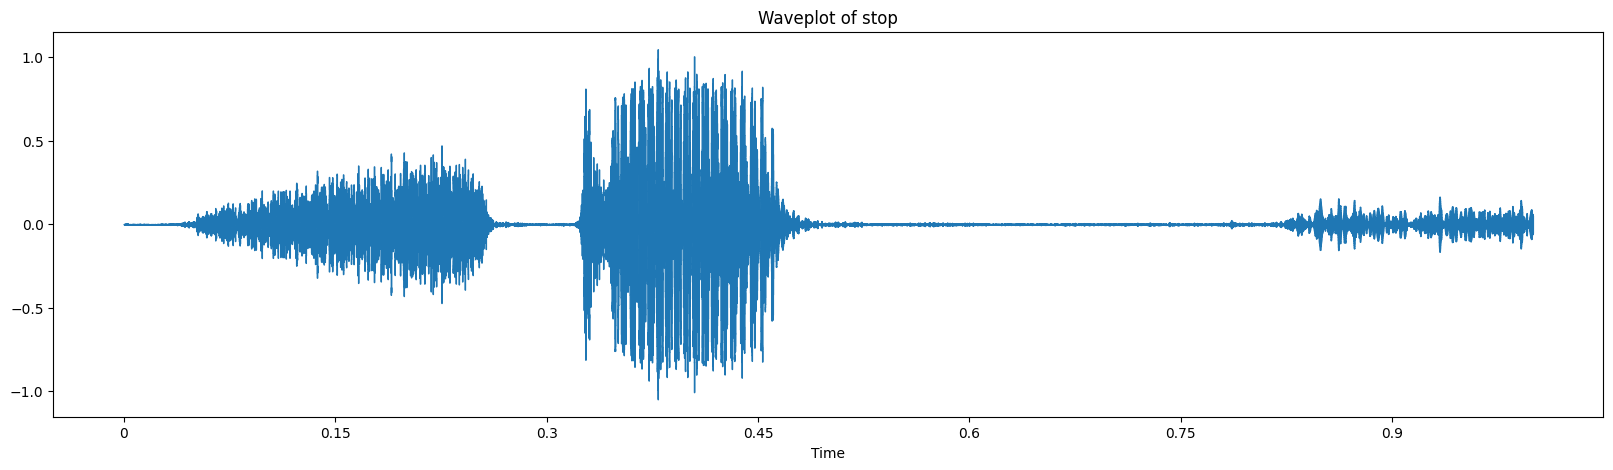

(20, 44)


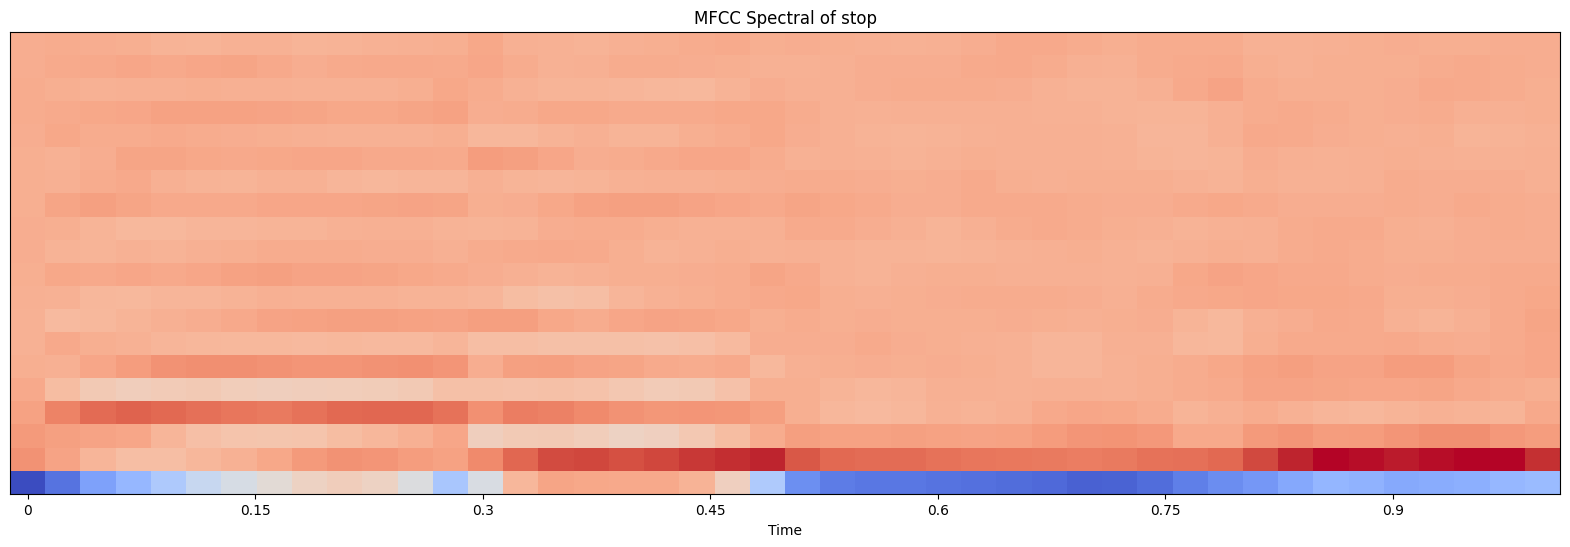

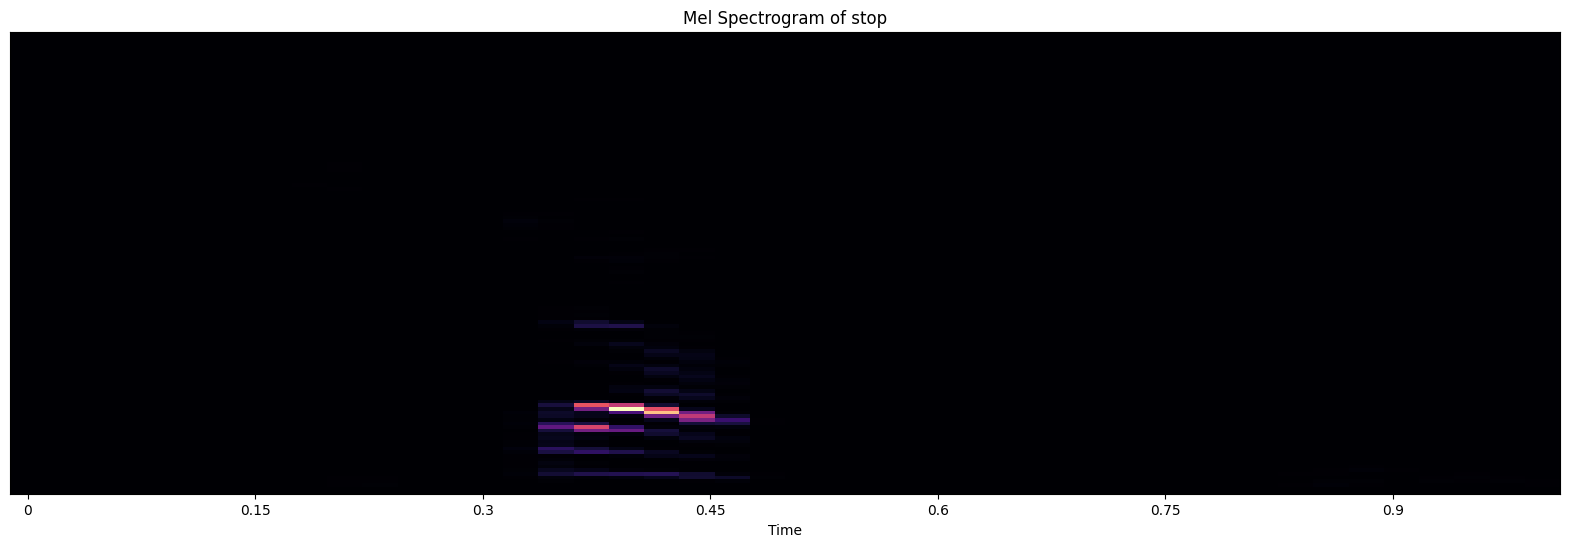

Sum of zero crossing  2984


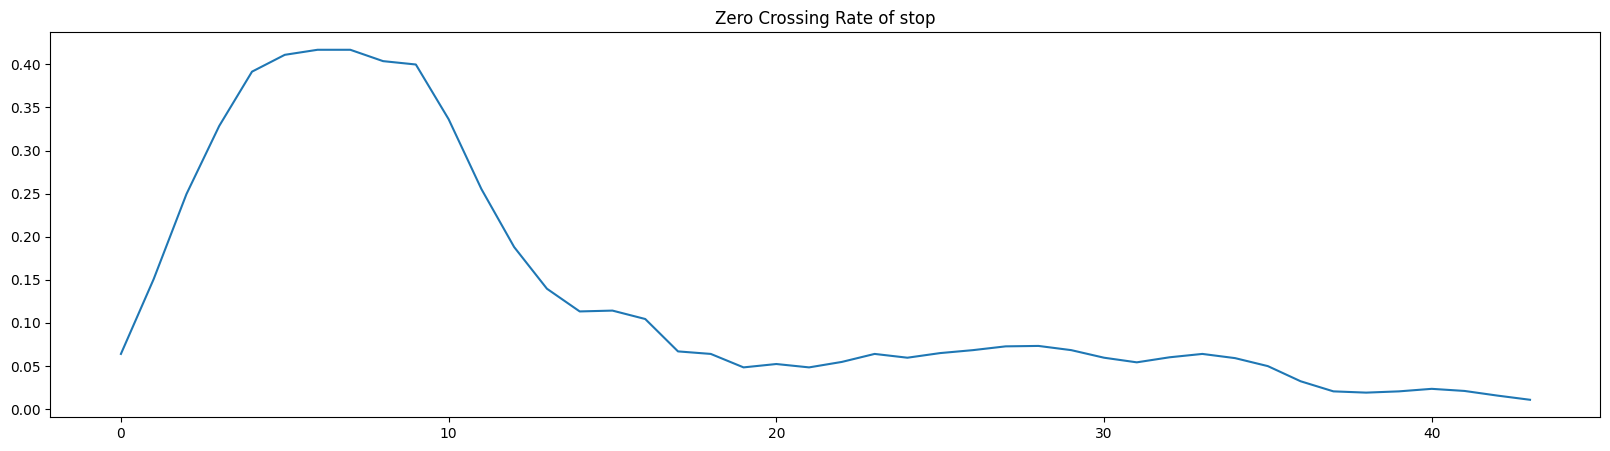

In [ ]:
sample = data[(data['target'] == 'stop')].sample(1)
get_audio_feature_plots(sample['filename'].values[0], sample['target'].values[0])
ipd.Audio(sample.filename.values[0])

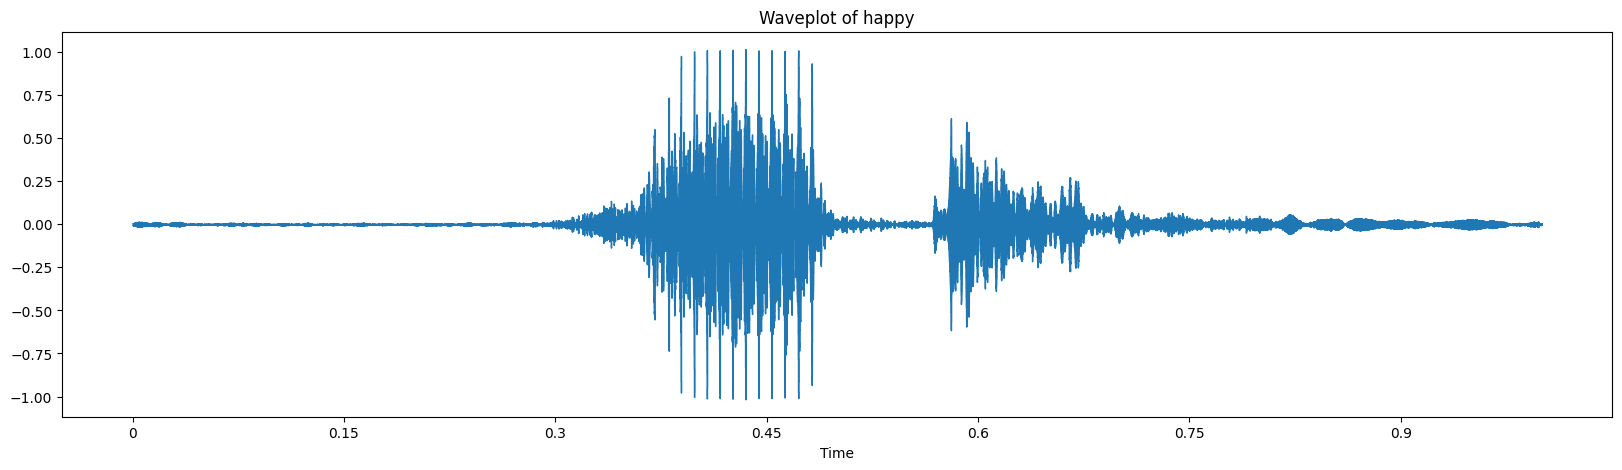

(20, 44)


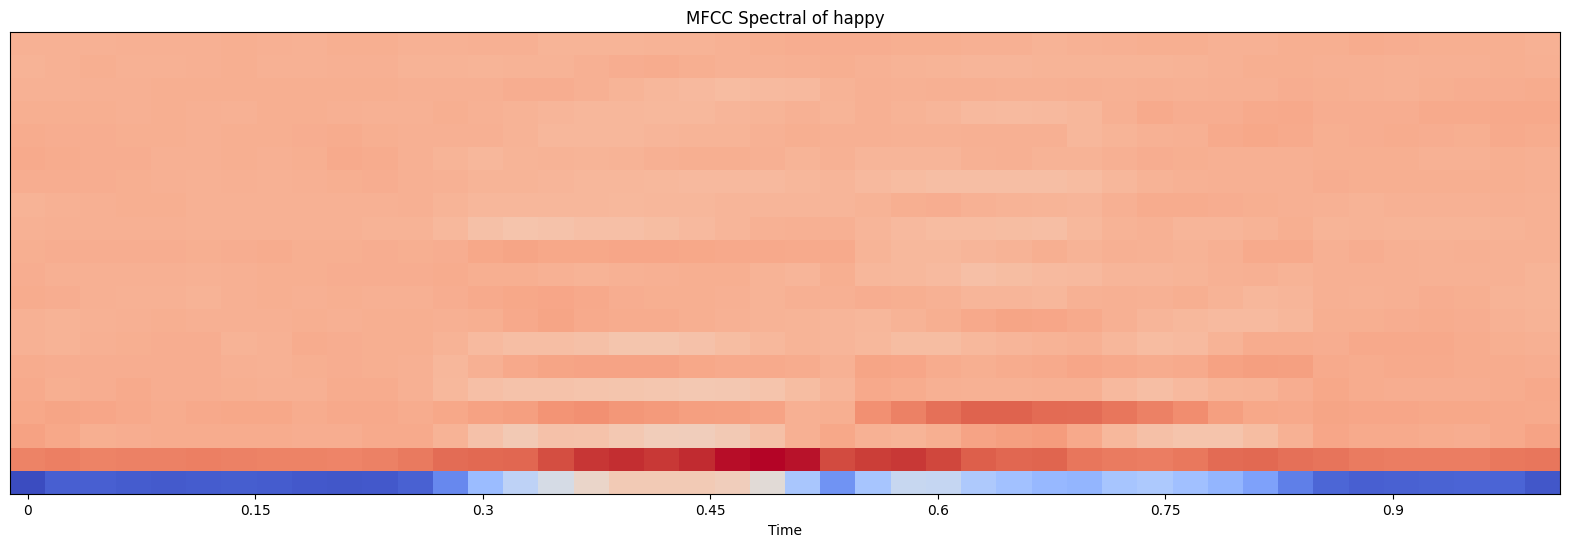

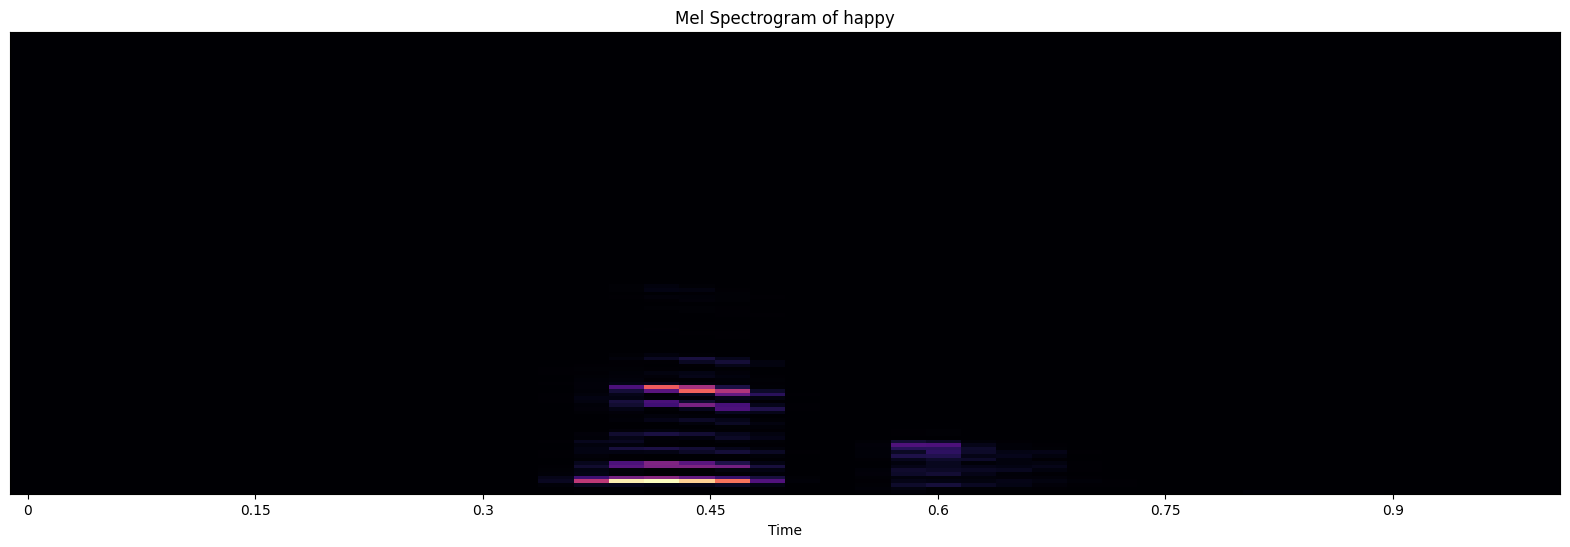

Sum of zero crossing  1053


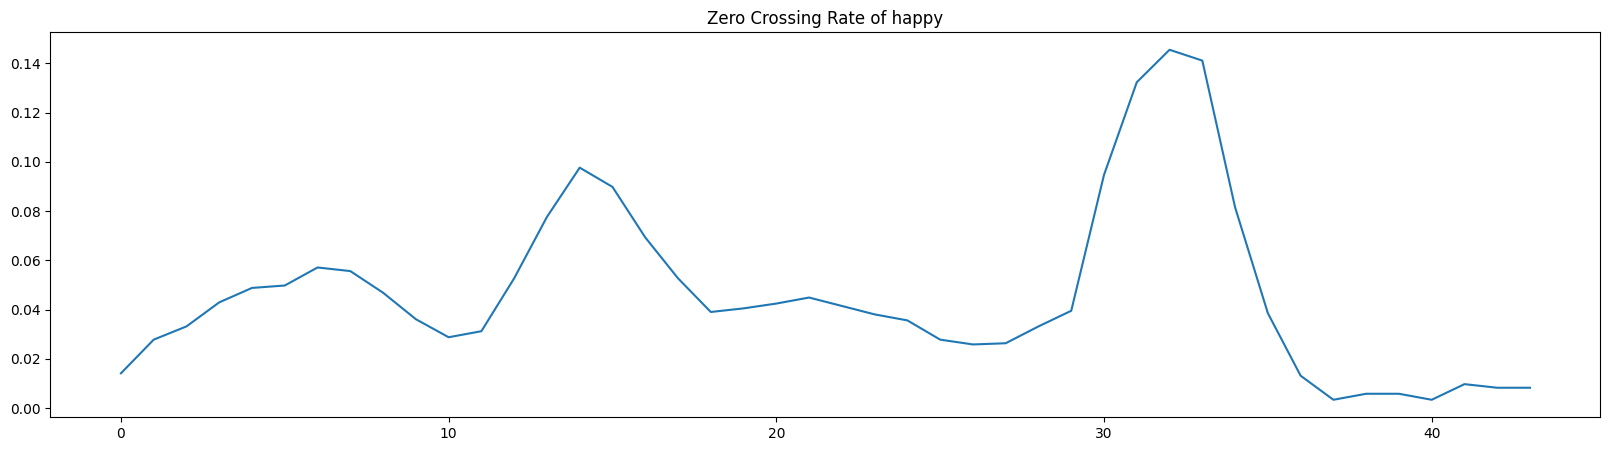

In [ ]:
sample = data[(data['target'] == 'happy')].sample(1)
get_audio_feature_plots(sample['filename'].values[0], sample['target'].values[0])
ipd.Audio(sample.filename.values[0])

# Feature Extractions

### Zero Cross Ratings

In [ ]:
def create_zero_cross_rating_features(path):
    zcrs = []
    try:
        x , sr = librosa.load(path)
        zcrs = librosa.feature.zero_crossing_rate(x)[0]
    except:
        print('Error reading audio')
    return zcrs

In [ ]:
#he resulting DataFrame has 44 columns, each corresponding to a zero-crossing rate value calculated for a specific audio file.

In [ ]:
%%time
X_df = pd.DataFrame(data['filename'].apply(lambda x: create_zero_cross_rating_features(x)).tolist())

CPU times: user 17.2 s, sys: 420 ms, total: 17.7 s
Wall time: 17.9 s


In [ ]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.023926,0.031250,0.042969,0.040039,0.048828,0.061035,0.072266,0.082031,0.089355,0.078125,...,0.047852,0.032227,0.036621,0.045410,0.058594,0.078125,0.074707,0.067871,0.048828,0.024414
1,0.014160,0.021484,0.031738,0.027832,0.030762,0.032715,0.029785,0.032227,0.026855,0.021973,...,0.086426,0.098633,0.113281,0.119141,0.123047,0.122559,0.107910,0.095215,0.060547,0.032715
2,0.035645,0.051758,0.069824,0.077148,0.083984,0.086914,0.091797,0.076172,0.065430,0.060059,...,0.056641,0.048340,0.047852,0.050781,0.047363,0.050293,0.048828,0.049805,0.038574,0.026855
3,0.039062,0.042969,0.064941,0.087891,0.068359,0.074707,0.064453,0.041016,0.040527,0.037109,...,0.025879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.058594,0.085449,0.122070,0.158203,0.156738,0.167480,0.152832,0.127441,0.132812,0.149414,...,0.072754,0.061035,0.072266,0.088867,0.085938,0.085938,0.061035,0.043457,0.033203,0.023926


In [ ]:
X_df.shape, data.shape

((5867, 44), (5867, 2))

In [ ]:
X_df.isnull().sum()

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      2
20      2
21      4
22      4
23     11
24     16
25     21
26     32
27     37
28     53
29     61
30     77
31     88
32    114
33    131
34    159
35    220
36    221
37    299
38    299
39    394
40    396
41    504
42    505
43    619
dtype: int64

In [ ]:
X_impute = X_df.copy()
X_impute = X_impute.fillna(0)
X_impute.isnull().sum().sum()

0

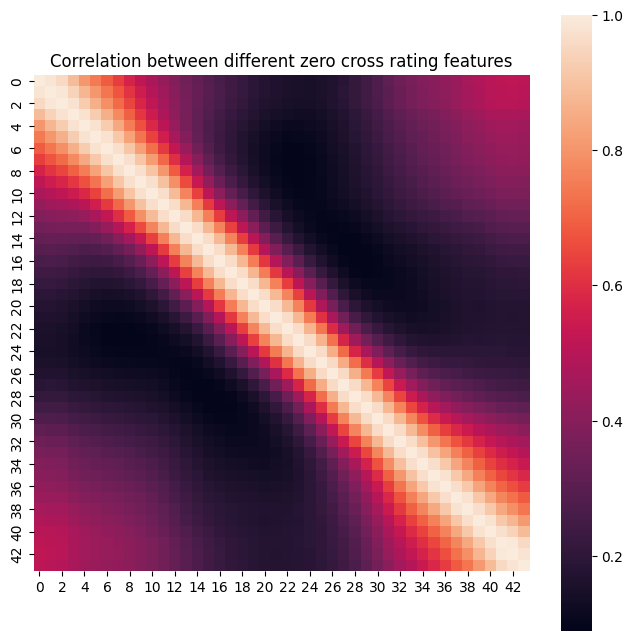

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(X_impute.corr(), vmax=1, square=True)

plt.title('Correlation between different zero cross rating features')
plt.show()

### PCA

In [ ]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_impute)

# Convert to dataframe
X_pca = pd.DataFrame(X_pca, columns=['PCA_'+str(i) for i in range(len(X_impute.columns))])

X_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43
0,-0.404497,-0.043976,0.031801,0.006920,0.066169,0.029843,0.019379,-0.044125,0.007995,-0.020114,...,0.000312,0.000474,0.000854,-0.000828,0.001534,-0.001496,0.001033,0.001464,-0.000560,0.000037
1,-0.431246,0.110323,0.110293,0.062789,-0.137455,0.113783,-0.081517,-0.030264,0.035991,0.049294,...,0.001842,0.002118,0.002557,0.000185,-0.002348,-0.002202,0.000557,0.000657,0.000032,-0.000350
2,-0.104315,0.359744,-0.201059,0.031446,-0.211999,-0.123272,-0.098884,-0.122509,-0.020453,0.025623,...,-0.003052,-0.001002,-0.001734,-0.000863,-0.002086,-0.000679,0.000216,-0.000448,-0.000532,-0.000077
3,-0.468296,-0.018354,-0.178871,-0.085502,-0.078379,-0.048564,0.000762,0.004917,-0.001745,-0.012554,...,-0.002776,-0.000034,0.001365,-0.004282,0.002505,0.003667,-0.000679,-0.001425,0.000637,0.000078
4,-0.067251,-0.090119,-0.100414,0.039579,-0.000843,-0.083066,-0.029360,-0.005470,0.005576,0.016742,...,-0.001428,0.000191,0.003104,-0.001008,-0.003204,0.000109,0.001253,-0.002013,0.000307,0.000911


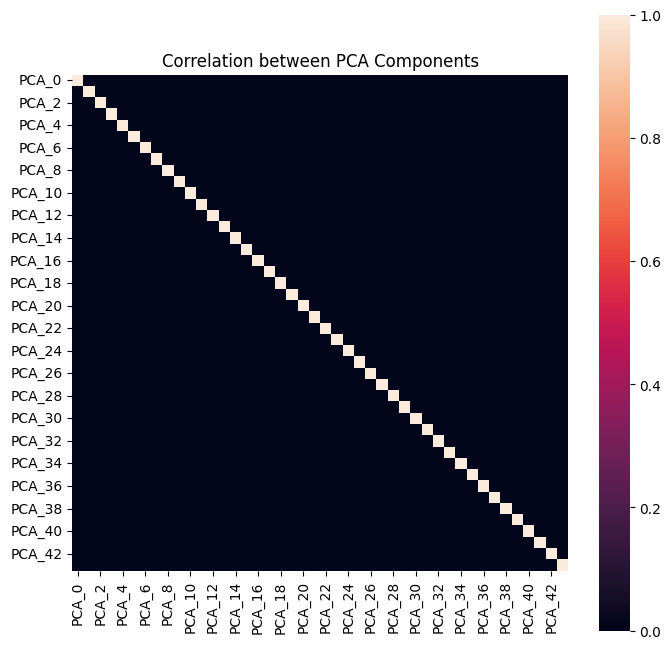

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(X_pca.corr(), vmax=1, square=True)

plt.title('Correlation between PCA Components')
plt.show()

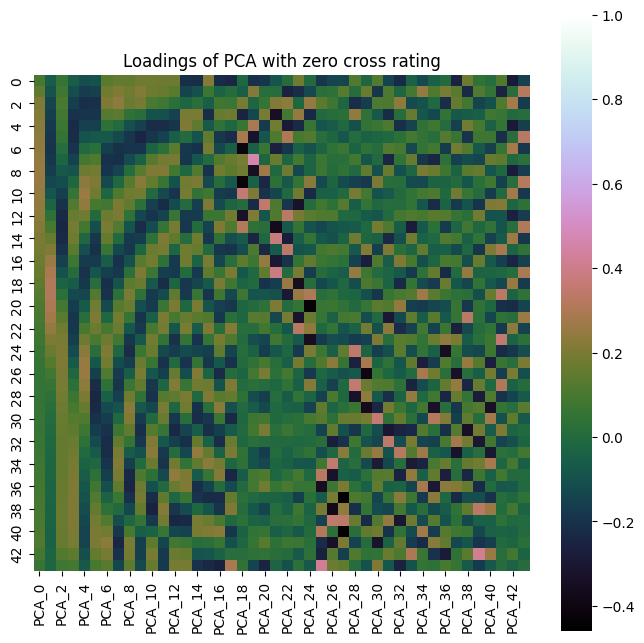

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=X_pca.columns,
    index=X_impute.columns,
)
plt.figure(figsize=(8,8))
sns.heatmap(loadings, vmax=1, square=True, cmap='cubehelix')

plt.title('Loadings of PCA with zero cross rating')
plt.show()

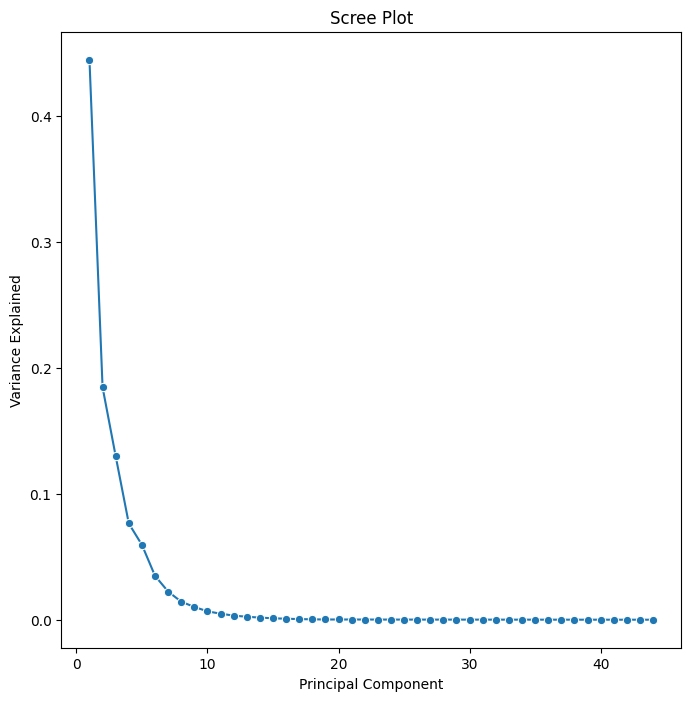

In [ ]:
x_values = np.arange(pca.n_components_) + 1
y_values = pca.explained_variance_ratio_
plt.figure(figsize=(8, 8))
sns.lineplot(x=x_values, y=y_values, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### KMeans

In [ ]:
opt_val = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_pca.iloc[:, :3])
    opt_val.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

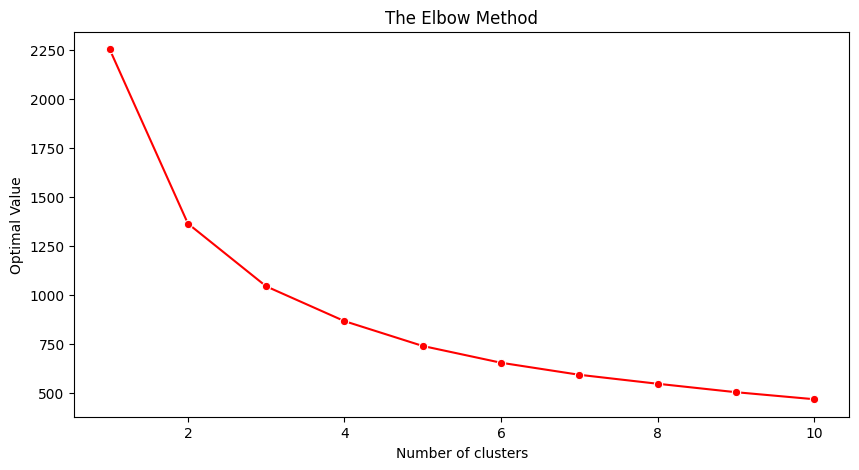

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined opt_val with the y-values for the line plot

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, 11), y=opt_val, marker='o', color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Optimal Value')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_pca.iloc[:, :3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
trace1 = go.Scatter3d(
    x= X_pca['PCA_0'],
    y= X_pca['PCA_1'],
    z= X_pca['PCA_2'],
    mode='markers',
     marker=dict(
        color = y_kmeans,
        size= 10,
        line=dict(
            color= y_kmeans,
            width= 12
        ),
        opacity=0.8
     )
)
data_plotly = [trace1]
layout = go.Layout(
    title= 'Clusters wrt three PCA Components',
    scene = dict(
            xaxis = dict(title  = 'PCA 0'),
            yaxis = dict(title  = 'PCA 1'),
            zaxis = dict(title  = 'PCA 2')
        )
)
fig = go.Figure(data=data_plotly, layout=layout)
fig.show()